In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt

Calibration

In [2]:
day_count = ql.Actual365Fixed()
calendar  = ql.NullCalendar()

calculation_date = ql.Date(6, 1, 2026)
spot = 93757

ql.Settings.instance().evaluationDate = calculation_date

risk_free_rate = [0.035, 0.035, 0.0371, 0.0364, 0.0364, 0.0357, 0.0347] #02/01/2026 0D,1D,1M,2M,3M,6M,1Y
risk_free_rate_date = [ql.Date(6, 1, 2026),
                       ql.Date(7, 1, 2026),
                       ql.Date(6, 2, 2026),
                       ql.Date(6, 3, 2026),
                       ql.Date(6, 4, 2026),
                       ql.Date(6, 7, 2026),
                       ql.Date(6, 1, 2027)]
zero_curve_ts = ql.YieldTermStructureHandle(ql.ZeroCurve(risk_free_rate_date, risk_free_rate, day_count, calendar))

dividend_rate = 0.0
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

In [3]:
time = 1
zeroCurve = []
for i in range(time*12 + 1):
    zeroCurve.append(zero_curve_ts.zeroRate(i/12, ql.Compounded, ql.Annual).rate())

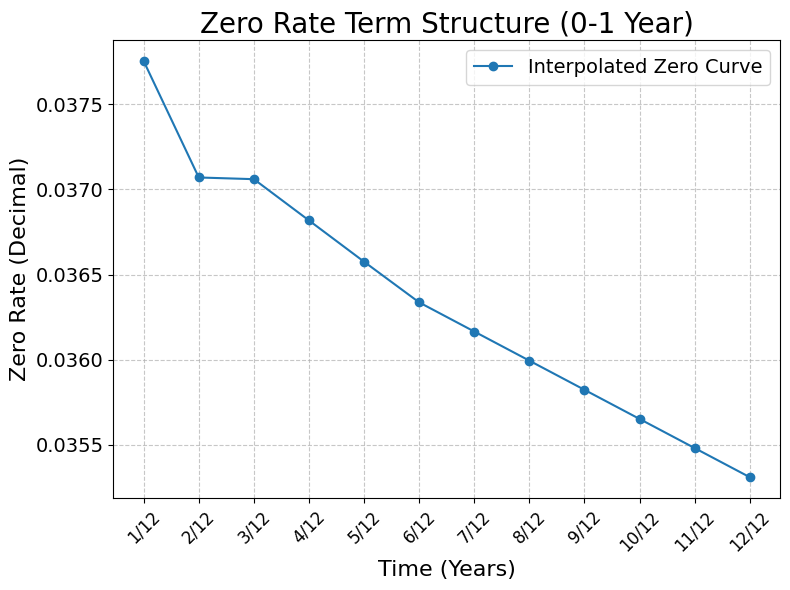

In [4]:
# 1. 準備 X 軸數據 (時間：0 到 1 年，共 13 個點)
time_timeline = [i/12 for i in range(1, 13)]

# 2. 設定圖表大小與解析度 (沿用你之前的風格)
fig = plt.figure(dpi=100, linewidth=2)
fig.set_size_inches(8, 6)

# 3. 繪圖
# 使用 'o-' (圓點+實線) 來顯示每個提取點的位置
plt.plot(time_timeline, zeroCurve[1:], 'o-', color='tab:blue', label="Interpolated Zero Curve")

# 4. 設定標題與軸標籤
plt.title("Zero Rate Term Structure (0-1 Year)", fontsize=20)
plt.xlabel("Time (Years)", fontsize=16)
plt.ylabel("Zero Rate (Decimal)", fontsize=16)

# 5. 細節調整 (刻度與格線)
plt.xticks(time_timeline, [f"{i}/12" for i in range(1, 13)], rotation=45, fontsize=12) # X軸刻度顯示月份
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7) # 加入格線方便對照數值

# 6. 顯示圖例與圖表
plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
# Dummy parameters for construct Heston model
v0 = 0.01; kappa = 0.20; theta = 0.02; rho = -0.75; sigma = 0.50
HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
HestonModel = ql.HestonModel(HestonProcess)
AHE = ql.AnalyticHestonEngine(HestonModel)

In [6]:
# 合約到期日
expiration_dates = [ql.Date(30, 1, 2026), ql.Date(27, 2, 2026)]
# 合約標的
strikes = [80000, 90000, 94000, 98000, 102000, 110000]
# 合約標的的隱含波動率
data = [[0.48355551, 0.42785803, 0.41907937, 0.41776776, 0.41891277, 0.43099922],
        [0.46285906, 0.43329618, 0.42213554, 0.42037845, 0.41953087, 0.42465031]]

# Implied Volatility Matrix
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]
        
black_var_surface = ql.BlackVarianceSurface(calculation_date, calendar, expiration_dates, strikes, implied_vols, day_count)

In [7]:
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
# maturity_idx = 1
# date = expiration_dates[maturity_idx]

for maturity_idx in range(len(expiration_dates)):
    date = expiration_dates[maturity_idx]
    for j, s in enumerate(strikes):
        t = (date - calculation_date)
        period = ql.Period(t, ql.Days)
        vol = data[maturity_idx][j]
        helper = ql.HestonModelHelper(period, calendar, spot, s, 
                                    ql.QuoteHandle(ql.SimpleQuote(vol)),
                                    zero_curve_ts, 
                                    dividend_ts)
        helper.setPricingEngine(AHE)
        heston_helpers.append(helper)

HestonModel.calibrate(heston_helpers, ql.LevenbergMarquardt(), ql.EndCriteria(500, 50, 1.0e-8, 1.0e-8, 1.0e-8))

theta, kappa, sigma, rho, v0 = HestonModel.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))

theta = 0.207665, kappa = 18.822330, sigma = 2.955578, rho = -0.185312, v0 = 0.187719


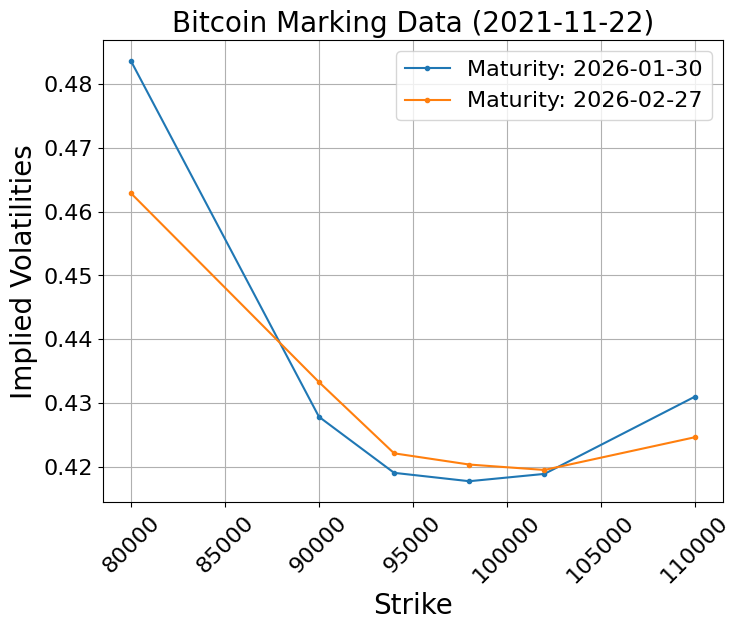

In [8]:
fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
for i in range(len(data)):
    plt.plot(strikes, data[i], '.-', label = f"Maturity: {expiration_dates[i].ISO()}")

plt.title("Bitcoin Marking Data (2021-11-22)", fontsize = 20)

plt.xticks(fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Implied Volatilities", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)
plt.grid()

plt.show()

In [9]:
# 上面的maturity_idx用來跑迴圈，每個maturity_idx都要calibration到，這邊的maturity_idx用來指定下面要算哪個maturity
maturity_idx = 1
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
maturity = expiration_dates[maturity_idx]
europeanExer = ql.EuropeanExercise(maturity)

call = []
put = []

In [10]:
for i, strike in enumerate(strikes):
    vol = data[maturity_idx][i]
    volTS = ql.BlackConstantVol(calculation_date, calendar, vol, day_count)
    h_volTS = ql.BlackVolTermStructureHandle(volTS)

    # (Spot, Div, Rate, Vol)
    bs_process = ql.BlackScholesMertonProcess(spot_handle, dividend_ts, zero_curve_ts, h_volTS)

    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
    AEE = ql.AnalyticEuropeanEngine(bs_process)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AEE)

    call.append(anEuroOption.NPV())
    
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Put, strike)
    AEE = ql.AnalyticEuropeanEngine(bs_process)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AEE)

    put.append(anEuroOption.NPV())


In [11]:
HestonProcess = ql.HestonProcess(zero_curve_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
HestonModel = ql.HestonModel(HestonProcess)
AHE = ql.AnalyticHestonEngine(HestonModel)

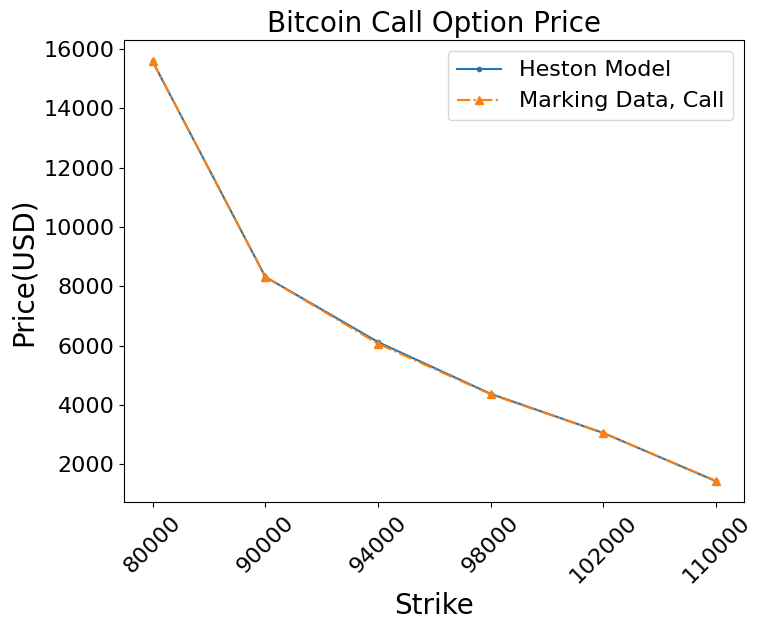

        Strikes    Marking Data    Heston Model    Relative Error(%)
          80000 15582.08667551179         15585.8            0.02
          90000 8320.32883404952          8322.0            0.02
          94000 6069.127606991377          6124.1            0.91
          98000 4361.628761068045          4378.0            0.38
         102000 3053.6926493725405          3057.8            0.13
         110000 1444.1606965481512          1431.1            -0.9
Error: 0.39(%)


In [12]:
call_Heston = []
for i in strikes:
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, i)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AHE)
    call_Heston.append(anEuroOption.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(strikes)), call_Heston, '.-', label = "Heston Model")
plt.plot(range(len(strikes)), call, '^-.', label = "Marking Data, Call")

plt.title("Bitcoin Call Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(strikes)):
    xticks_number.append(i)
    xticks_name.append(strikes[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()

avg = 0.0
print("%15s %15s %15s %20s" % ("Strikes", "Marking Data", "Heston Model", "Relative Error(%)"))
print("="*100)
for i in range(len(strikes)):
    err = (call_Heston[i]/call[i] - 1.0)
    print("%15s %15s %15s %15s" % (strikes[i], call[i], round(call_Heston[i],1), round(100.0*err, 2)))
    avg += abs(err)*100/len(strikes)
print("="*100)
print("Error: " + str(round(avg, 2)) + '(%)')

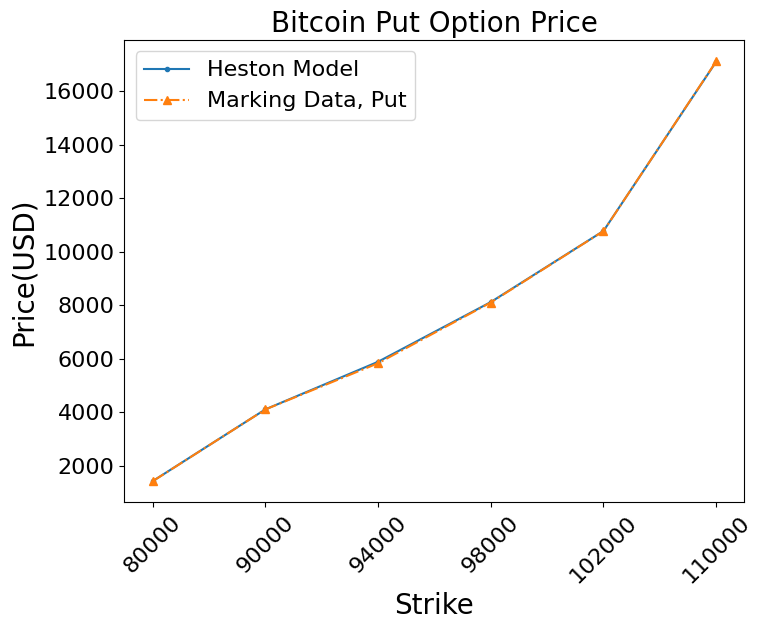

        Strikes    Marking Data    Heston Model    Relative Error(%)
          80000 1409.3160465902724          1413.0            0.26
          90000 4095.5868765128216          4097.2            0.04
          94000 5823.5971180086035          5878.5            0.94
          98000 8095.309740639195          8111.7             0.2
         102000 10766.585097497615         10770.6            0.04
         110000 17115.476081781064         17102.4           -0.08
Error: 0.26(%)


In [13]:
put_Heston = []
for i in strikes:
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Put, i)
    anEuroOption = ql.EuropeanOption(vanillaPayoff, europeanExer)
    anEuroOption.setPricingEngine(AHE)
    put_Heston.append(anEuroOption.NPV())

fig = plt.figure(dpi = 100, linewidth = 2)
fig.set_size_inches(8, 6)
    
plt.plot(range(len(strikes)), put_Heston, '.-', label = "Heston Model")
plt.plot(range(len(strikes)), put, '^-.', label = "Marking Data, Put")

plt.title("Bitcoin Put Option Price", fontsize = 20)

xticks_number = []
xticks_name = []
for i in range(len(strikes)):
    xticks_number.append(i)
    xticks_name.append(strikes[i])
plt.xticks(xticks_number, xticks_name, fontsize = 16, rotation = 45)
plt.xlabel("Strike", fontsize = 20)

plt.yticks(fontsize = 16)
plt.ylabel("Price(USD)", fontsize = 20)

plt.legend(loc = "best", fontsize = 16)

plt.show()

avg = 0.0
print("%15s %15s %15s %20s" % ("Strikes", "Marking Data", "Heston Model", "Relative Error(%)"))
print("="*100)
for i in range(len(strikes)):
    err = (put_Heston[i]/put[i] - 1.0)
    print("%15s %15s %15s %15s" % (strikes[i], put[i], round(put_Heston[i],1), round(100.0*err, 2)))
    avg += abs(err)*100/len(strikes)
print("="*100)
print("Error: " + str(round(avg, 2)) + '(%)')